In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [5]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import json
from IPython.core.debugger import set_trace
from matplotlib import patheffects, patches
from pathlib import Path

# Inspect and transform data

Data source [Pascal 2007](https://pjreddie.com/projects/pascal-voc-dataset-mirror/)

In [6]:
PATH = Path('/media/Data/Documents/Notebooks/data/pascal/')
list(PATH.iterdir())

[PosixPath('/media/Data/Documents/Notebooks/data/pascal/pascal_test2007.json'),
 PosixPath('/media/Data/Documents/Notebooks/data/pascal/pascal_train2007.json'),
 PosixPath('/media/Data/Documents/Notebooks/data/pascal/pascal_train2012.json'),
 PosixPath('/media/Data/Documents/Notebooks/data/pascal/pascal_val2007.json'),
 PosixPath('/media/Data/Documents/Notebooks/data/pascal/pascal_val2012.json'),
 PosixPath('/media/Data/Documents/Notebooks/data/pascal/test2007'),
 PosixPath('/media/Data/Documents/Notebooks/data/pascal/train2007'),
 PosixPath('/media/Data/Documents/Notebooks/data/pascal/VOCtest'),
 PosixPath('/media/Data/Documents/Notebooks/data/pascal/VOCtrainval')]

In [69]:
JPEGS = 'train2007'

In [70]:
TRN_PATH = PATH/JPEGS
list(TRN_PATH.iterdir())[:4]

[PosixPath('/media/Data/Documents/Notebooks/data/pascal/train2007/000005.jpg'),
 PosixPath('/media/Data/Documents/Notebooks/data/pascal/train2007/000007.jpg'),
 PosixPath('/media/Data/Documents/Notebooks/data/pascal/train2007/000009.jpg'),
 PosixPath('/media/Data/Documents/Notebooks/data/pascal/train2007/000012.jpg')]

Label source in JSON format [here](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip)

In [8]:
train_j = json.load((PATH/'pascal_train2007.json').open())
train_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

## Images

In [9]:
IMAGES, TYPE, ANNOTATION, CATEGORIES = ['images', 'type', 'annotations', 'categories']

In [10]:
train_j[IMAGES][:4], train_j[IMAGES][0].keys()

([{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
  {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
  {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
  {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26}],
 dict_keys(['file_name', 'height', 'width', 'id']))

In [11]:
FILE_NAME, ID = ['file_name', 'id']

The training data will be named after the image id from `train_j[IMAGES]` so we need a list with all the image id's and a dictionary to find file_name with that id.

In [12]:
trn_ids = [o[ID] for o in train_j[IMAGES]]
trn_fln = {o[ID]:o[FILE_NAME] for o in train_j[IMAGES]}

In [13]:
trn_ids[:4], trn_fln[12]

([12, 17, 23, 26], '000012.jpg')

In [14]:
trn_fln[12]

'000012.jpg'

In [15]:
train_j[TYPE]

'instances'

## Categories

In [16]:
train_j[CATEGORIES][:4]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'}]

In [17]:
cats = {o[ID]:o['name'] for o in train_j[CATEGORIES]}

In [18]:
cats[1], cats[2]

('aeroplane', 'bicycle')

## Annotation

In [19]:
train_j[ANNOTATION][:3], train_j[ANNOTATION][0].keys()

([{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
   'area': 34104,
   'iscrowd': 0,
   'image_id': 12,
   'bbox': [155, 96, 196, 174],
   'category_id': 7,
   'id': 1,
   'ignore': 0},
  {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
   'area': 13110,
   'iscrowd': 0,
   'image_id': 17,
   'bbox': [184, 61, 95, 138],
   'category_id': 15,
   'id': 2,
   'ignore': 0},
  {'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]],
   'area': 81326,
   'iscrowd': 0,
   'image_id': 17,
   'bbox': [89, 77, 314, 259],
   'category_id': 13,
   'id': 3,
   'ignore': 0}],
 dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id', 'ignore']))

In [20]:
IMAGE_ID, BBOX, CATEGORY_ID, ID, IGNORE = ['image_id', 'bbox', 'category_id', 'id', 'ignore']

Now I want a dictionary with image_id as key and tuples of bb and cat as values. I want to append new values to an existing list so all keys need to be activated as keys with empty lists as they are called but I don't want to save all possible keys so I use a `defaultdict`.

I also need a function to convert current bb to minmax x,y and swap x and y

In [21]:
def bb_tocorners(bb):
    '''
    Original, imageprocesing-style, coordinates are, counted from topleft corner: topleft_x, topleft_y, width, hight.
    New, numpy-style, coordinates are topleft_y, topleft_x, bottomright_y, bottomright_x.
    '''
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

In [22]:
def bb_tohw(bb):
    '''
    Reverse of bb_tocorners(bb), make ready for imageprocessing software.
    From numpy-style coordinates, counted from topleft corner:  topleft_y, topleft_x, bottomright_y, bottomright_x.
    To imageprocesing-style coordinates: topleft_x, topleft_y, width, hight.
    '''
    return np.array([bb[1], bb[0], bb[3]-bb[1]+1, bb[2]-bb[0]+1])

In [23]:
# trn_anno = {id: [([bb], category_id), (...)]}
trn_anno = collections.defaultdict(lambda:[])
for o in train_j[ANNOTATION]:
    if not o['ignore']:
        trn_anno[o[IMAGE_ID]].append((bb_tocorners(o[BBOX]), o[CATEGORY_ID]))

len(trn_anno)

2501

In [24]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [25]:
f = lambda x: (x[0][2]-x[0][0])*(x[0][3]-x[0][1])

In [26]:
for box in trn_anno[17]:
    print(box, f(box))

(array([ 61, 184, 198, 278]), 15) 12878
(array([ 77,  89, 335, 402]), 13) 80754


In [27]:
def get_lrgst(annos):
    if not annos: raise Exception()
    b = sorted(annos, key=lambda x: (x[0][2]-x[0][0])*(x[0][3]-x[0][1]), reverse=True)
    return b[0]

In [28]:
trn_anno[17], get_lrgst(trn_anno[17])

([(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)],
 (array([ 77,  89, 335, 402]), 13))

In [29]:
lrgst = {index:get_lrgst(trn_anno[index]) for index in trn_anno}

## Some plotting tools

In [30]:
import cv2
import os

def open_image(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        #res = np.array(Image.open(fn), dtype=np.float32)/255
        #if len(res.shape)==2: res = np.repeat(res[...,None],3,2)
        #return res
        try:
            im = cv2.imread(str(fn), flags).astype(np.float32)/255
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [31]:
def show_img(IMAGE_ID, figsize=None, ax=None):
    im = open_image(TRN_PATH/trn_fln[IMAGE_ID])
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

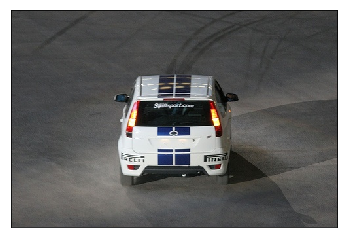

In [32]:
show_img(12)

In [33]:
def draw_outline(o, lw=4):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

In [34]:
def draw_cat(image_id, numpystyle=True, sz=14):
    ax = show_img(image_id)
    det = lrgst[image_id]
    if numpystyle == True:
        xy = det[0][:2][::-1]
    else:
        xy = det[0][:2]
    texted_ax = ax.text(*xy, cats[det[1]], 
                        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(texted_ax)

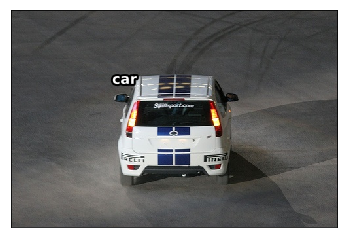

In [35]:
draw_cat(12)

In [36]:
def draw_rect(image_id, numpystyle=True, sz=14):
    ax = show_img(image_id)
    box = lrgst[image_id][0]
    if numpystyle == True:
        box = bb_tohw(box)
    patched_ax = ax.add_patch(patches.Rectangle(box[:2], box[2], box[3], 
                                   fill=False, edgecolor='white', lw=2))
    draw_outline(patched_ax)

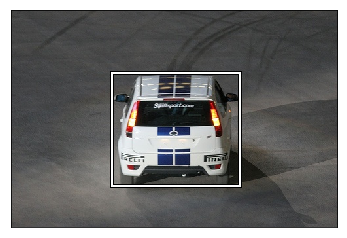

In [37]:
draw_rect(12)

In [38]:
def draw_catrect(image_id, numpystyle=True, sz=14, bxlw=2, ollw=4):
    ax = show_img(image_id)
    box = lrgst[image_id][0]
    det = lrgst[image_id]
    if numpystyle == True:
        box = bb_tohw(box)
        xy = det[0][:2][::-1]
    else:
        xy = det[0][:2]
    draw_outline(ax.text(*xy, cats[det[1]], 
            verticalalignment='top', color='white', fontsize=sz, weight='bold'), ollw)
    draw_outline(ax.add_patch(patches.Rectangle(box[:2], box[2], box[3], 
                                   fill=False, edgecolor='white', lw=bxlw)), ollw)
#     ax.set_path_effects([patheffects.Stroke(linewidth=ollw, foreground='black'), patheffects.Normal()])

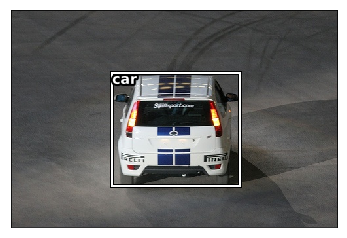

In [39]:
draw_catrect(12)

In [40]:
def draw_cat(image_id, onl_lrg=True, numpystyle=True, sz=14):
    '''
    Draws image and categories.
    onl_lrg: only draw largests category
    numpystyle: take bounding box in topleft yx, bottomright yx
    '''
    ax = show_img(image_id)
    if onl_lrg == True:
        details = [lrgst[image_id]]
    else:
        details = trn_anno[image_id]
    for annos in details:
        if numpystyle == True:
            xy = annos[0][:2][::-1]
        else:
            xy = annos[0][:2]
        draw_outline(ax.text(*xy, cats[annos[1]], 
                            verticalalignment='top', color='white', fontsize=sz, weight='bold'))

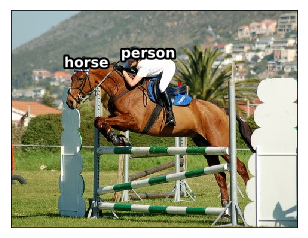

In [41]:
draw_cat(17, False)

In [42]:
def draw_rect(image_id, onl_lrg=True, numpystyle=True, sz=14, bxlw=2, ollw=4):
    '''
    Draws image and boundingboxes.
    onl_lrg: only draw largests bounding box
    numpystyle: take bounding box in topleft yx, bottomright yx
    '''
    ax = show_img(image_id)
    if onl_lrg == True:
        details = [lrgst[image_id]]
    else:
        details = trn_anno[image_id]
    for annos in details:
        box = annos[0]
        if numpystyle == True:
            box = bb_tohw(box)
        draw_outline(ax.add_patch(patches.Rectangle(box[:2], box[2], box[3], 
                                   fill=False, edgecolor='white', lw=bxlw)), ollw)

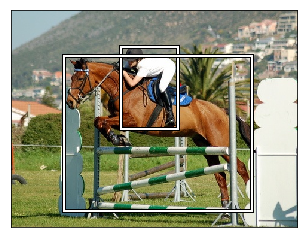

In [43]:
draw_rect(17, False)

In [44]:
def draw_catrect(image_id, onl_lrg=True, numpystyle=True, sz=14, bxlw=2, ollw=4, figsize=None):
    '''
    Draws image and categories.
    
    onl_lrg: only draw largests category
    numpystyle: take bounding box in topleft yx, bottomright yx
    sz: font size
    bxlw: box line width
    ollw: outline line width
    '''
    ax = show_img(image_id, figsize)
    if onl_lrg == True:
        details = [lrgst[image_id]]
    else:
        details = trn_anno[image_id]
    for annos in details:
        box = annos[0]
        if numpystyle == True:
            xy = annos[0][:2][::-1]
            box = bb_tohw(box)
        else:
            xy = annos[0][:2]
        draw_outline(ax.text(*xy, cats[annos[1]], 
                verticalalignment='top', color='white', fontsize=sz, weight='bold'), ollw)
        draw_outline(ax.add_patch(patches.Rectangle(box[:2], box[2], box[3], 
                                       fill=False, edgecolor='white', lw=bxlw)), ollw)

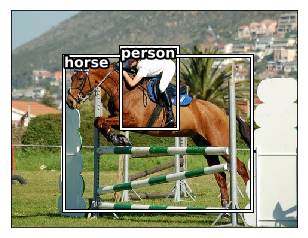

In [45]:
draw_catrect(17, False)

## Largest item classifier

In [46]:
import pandas as pd

In [59]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

In [60]:
df = pd.DataFrame({'fn': [trn_fln[trn_id] for trn_id in trn_ids],
                  'cat': [lrgst[trn_id][1] for trn_id in trn_ids]}, columns=['fn', 'cat'])

In [61]:
df.head()

,fn,cat
0,000012.jpg,7
1,000017.jpg,13
2,000023.jpg,15
3,000026.jpg,7
4,000032.jpg,1


In [62]:
df.to_csv(CSV, index=False)

In [65]:
from fastai.conv_learner import *
from fastai.dataset import *

/home/stijn/Software/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [66]:
f_model = resnet34
sz = 224
bs = 64

In [71]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, bs, tfms)

In [72]:
x, y = next(iter(md.val_dl))

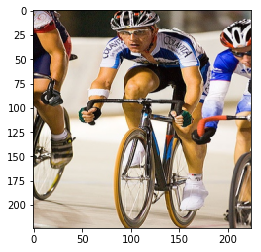

In [85]:
plt.imshow(md.val_ds.denorm(to_np(x))[0])

In [86]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/stijn/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:14<00:00, 6189218.59it/s] 


In [87]:
lrf = learn.lr_find(1e-5, 100)

 81%|████████▏ | 26/32 [05:10<01:11, 11.96s/it, loss=25.5]

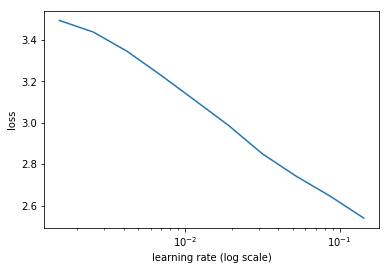

In [88]:
learn.sched.plot()

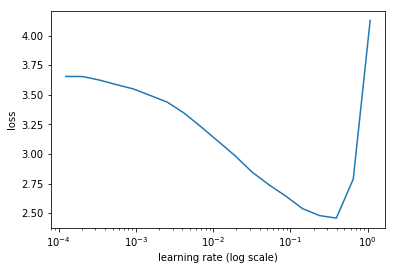

In [89]:
learnrn.sched.plot(n_skip=5, n_skip_end=1)